In [1]:
import xarray as xr
import numpy as np 
import netCDF4 as nc

In [99]:

def subset_3d_array (dataset, lat, lat_range, lon, lon_range):
    """
    take a 3D data field and do a zonal mean, i.e. across a latitude circle,
    over a given lat range
    i.e. zonal mean of 20S-20N datc
    """
    import numpy as np
    lat_min = lat_range[0]
    lat_max = lat_range[1]
    lat_max_idx = np.abs(lat - lat_max).argmin()
    lat_min_idx = np.abs(lat - lat_min).argmin()
    lon_min = lon_range[0]
    lon_min_idx = np.abs(lon - lon_min).argmin()
    lon_max = lon_range[1]
    lon_max_idx = np.abs(lon - lon_max).argmin()
    # subset the data into the months of interest and the lat region of interest
    datasubset = dataset[:,:,lat_min_idx:lat_max_idx, lon_min_idx:lon_max_idx]
    # take zonal mean
    #print lat_min_idx, lat_max_idx, lon_min_idx, lon_max_idx, np.shape(datasubset)
    return [lat_min_idx,lat_max_idx], [lon_min_idx,lon_max_idx], datasubset

def subset_2d_array (dataset, lat, lat_range, lon, lon_range):
    """
    take a 3D data field and do a zonal mean, i.e. across a latitude circle,
    over a given lat range
    i.e. zonal mean of 20S-20N datc
    """
    import numpy as np
    lat_min = lat_range[0]
    lat_max = lat_range[1]
    lat_max_idx = np.abs(lat - lat_max).argmin()
    lat_min_idx = np.abs(lat - lat_min).argmin()
    lon_min = lon_range[0]
    lon_min_idx = np.abs(lon - lon_min).argmin()
    lon_max = lon_range[1]
    lon_max_idx = np.abs(lon - lon_max).argmin()
    # subset the data into the months of interest and the lat region of interest
    datasubset = dataset[:,:,lat_min_idx:lat_max_idx, lon_min_idx:lon_max_idx]
    # take zonal mean
    #print lat_min_idx, lat_max_idx, lon_min_idx, lon_max_idx, np.shape(datasubset)
    return [lat_min_idx,lat_max_idx], [lon_min_idx,lon_max_idx], datasubset


In [4]:
lat_range=[-20,20]
lon_range=[0,360]

In [83]:
files = [
    'BC_biofuel_anthropogenic_1849_2015_time_series.nc',
    'BC_fossil_anthropogenic_1849_2015_time_series.nc',
    'C2H6_anthropogenic_1849_2015_time_series.nc',
    'C3H8_anthropogenic_1849_2015_time_series.nc',
    'CH4_anthropogenic_1849_2015_time_series.nc',
    'CO_anthropogenic_1849_2015_time_series.nc',
    'HCHO_anthropogenic_1849_2015_time_series.nc',
    'Me2CO_anthropogenic_1849_2015_time_series.nc',
    'MeCHO_anthropogenic_1849_2015_time_series.nc',
    'MeOH_anthropogenic_1849_2015_time_series.nc',
    'NH3_anthropogenic_1849_2015_time_series.nc',
    'NO_anthropogenic_1849_2015_time_series.nc',
    'NVOC_anthropogenic_1849_2015_time_series.nc',
    'OC_biofuel_anthropogenic_1849_2015_time_series.nc',
    'OC_fossil_anthropogenic_1849_2015_time_series.nc',
    'SO2_all_low_anthropogenic_1849_2015_time_series.nc',
    'SO2_high_anthropogenic_1849_2015_time_series.nc',
    'SO2_low_anthropogenic_1849_2015_time_series.nc'
    ]

variables = [
    'emissions_BC_biofuel',
    'emissions_BC_fossil',
    'emissions_C2H6',
    'emissions_C3H8',
    'emissions_CH4',
    'emissions_CO',
    'emissions_HCHO',
    'emissions_Me2CO',
    'emissions_MeCHO',
    'emissions_MeOH',
    'emissions_NH3',
    'emissions_NO',
    'emissions_NVOC',
    'emissions_OC_biofuel',
    'emissions_OC_fossil',
    'emissions_SO2_all_low_kgSO2',
    'emissions_SO2_high_kgSO2',
    'emissions_SO2_low_kgSO2'
]

In [86]:
disk='/gws/nopw/j04/htap2/ptg21/OPT/emianox/'

ivar=0
for file,vari in zip(files,variables):
    ivar=ivar+1
    names = file.split('_')
    outfile = names[0]+'_'+names[1]
    print(outfile+'\n')
    CMIP6_anthro = xr.open_dataset(disk+file)
    # select data from 1995-2014 from ancil
    CMIP6_anthro_1995_2014 = CMIP6_anthro.sel(time = slice('1994-12-01','2015-01-01'))
    # get the 1995 data for use as constant emissisions within tropics
    CMIP6_anthro_1995_data = CMIP6_anthro_1995_2014.sel(time = slice('1994-12-01','1996-01-01'))[vari]
    # get subset of 1995 data over required lat and lon ranges
    lat_idxs, lon_idxs, subset_CMIP6_anthro_1995_data = subset_2d_array(CMIP6_anthro_1995_data.data,
                                                        CMIP6_anthro_1995_data['latitude'].data[:], lat_range,     
                                                        CMIP6_anthro_1995_data['longitude'].data[:], lon_range)    
    # empty array to cover 1995-2014 for filling
    const_1995_ems  = np.ones((20*12+1,1,144,192))
    # fill with base data from transient 1995-2014
    const_1995_ems = np.array(CMIP6_anthro_1995_2014[vari].data) # good lord!  constant 1995_ems remains a dataarray object unless you do this.
    # make sure first element (i.e. december 1994) is available since 1995-01-01 requires it and ems are in the middle of the month!
    const_1995_ems[0,...] = CMIP6_anthro_1995_data.data[-1,...]

    # for each year overwrite the required region with the 1995 data
    for ivar in range (0,19):
        # overwrite data within region with constant 1995 data
        const_1995_ems[ivar*12+1:(ivar+1)*12+1,:,lat_idxs[0]:lat_idxs[1],lon_idxs[0]:lon_idxs[1]] = subset_CMIP6_anthro_1995_data[1:,:,:,:]

    CMIP6_anthro_const_1995 = CMIP6_anthro_1995_2014.copy(deep=True)
    CMIP6_anthro_const_1995[vari].data[:] = const_1995_ems
    CMIP6_anthro_const_1995[vari].compute()
    CMIP6_anthro_const_1995.to_netcdf('1995_2015_'+vari+'_constant_tropic.nc')

BC_biofuel

BC_fossil

C2H6_anthropogenic

C3H8_anthropogenic

CH4_anthropogenic

CO_anthropogenic

HCHO_anthropogenic

Me2CO_anthropogenic

MeCHO_anthropogenic

MeOH_anthropogenic

NH3_anthropogenic

NO_anthropogenic

NVOC_anthropogenic

OC_biofuel

OC_fossil

SO2_all

SO2_high

SO2_low



## sanity check

/tmp/ipykernel_3318/3311774033.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(CMIP6_anthro_1995_data['longitude'].data[:],CMIP6_anthro_1995_data['latitude'].data[:],CMIP6_anthro_const_1995.emissions_SO2_low_kgSO2[228,0,:,:]-CMIP6_anthro_1995_2014.emissions_SO2_low_kgSO2[228,0,:,:], cmap='RdBu_r')


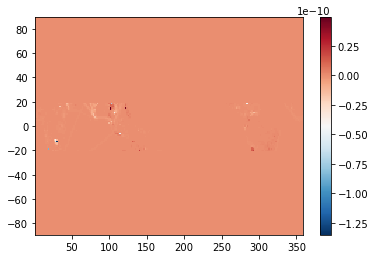

In [93]:
plt.pcolormesh(CMIP6_anthro_1995_data['longitude'].data[:],CMIP6_anthro_1995_data['latitude'].data[:],CMIP6_anthro_const_1995.emissions_SO2_low_kgSO2[228,0,:,:]-CMIP6_anthro_1995_2014.emissions_SO2_low_kgSO2[228,0,:,:], cmap='RdBu_r')
plt.colorbar()

In [97]:
files = ['NO_aircrft_anthropogenic_1849_2015_time_series.nc']
variables = ['emissions_NO_aircrft']

In [100]:
disk='/gws/nopw/j04/htap2/ptg21/OPT/emianox/'

ivar=0
for file,vari in zip(files,variables):
    ivar=ivar+1
    names = file.split('_')
    outfile = names[0]+'_'+names[1]
    print(outfile+'\n')
    CMIP6_anthro = xr.open_dataset(disk+file)
    # select data from 1995-2014 from ancil
    CMIP6_anthro_1995_2014 = CMIP6_anthro.sel(time = slice('1994-12-01','2015-01-01'))
    # get the 1995 data for use as constant emissisions within tropics
    CMIP6_anthro_1995_data = CMIP6_anthro_1995_2014.sel(time = slice('1994-12-01','1996-01-01'))[vari]
    # get subset of 1995 data over required lat and lon ranges
    lat_idxs, lon_idxs, subset_CMIP6_anthro_1995_data = subset_3d_array(CMIP6_anthro_1995_data.data,
                                                        CMIP6_anthro_1995_data['latitude'].data[:], lat_range,     
                                                        CMIP6_anthro_1995_data['longitude'].data[:], lon_range)    
    # empty array to cover 1995-2014 for filling
    const_1995_ems  = np.ones((20*12+1,85,144,192))
    # fill with base data from transient 1995-2014
    const_1995_ems = np.array(CMIP6_anthro_1995_2014[vari].data) # good lord!  constant 1995_ems remains a dataarray object unless you do this.
    # make sure first element (i.e. december 1994) is available since 1995-01-01 requires it and ems are in the middle of the month!
    const_1995_ems[0,...] = CMIP6_anthro_1995_data.data[-1,...]

    # for each year overwrite the required region with the 1995 data
    for ivar in range (0,19):
        # overwrite data within region with constant 1995 data
        const_1995_ems[ivar*12+1:(ivar+1)*12+1,:,lat_idxs[0]:lat_idxs[1],lon_idxs[0]:lon_idxs[1]] = subset_CMIP6_anthro_1995_data[1:,:,:,:]

    CMIP6_anthro_const_1995 = CMIP6_anthro_1995_2014.copy(deep=True)
    CMIP6_anthro_const_1995[vari].data[:] = const_1995_ems
    CMIP6_anthro_const_1995[vari].compute()
    CMIP6_anthro_const_1995.to_netcdf('1995_2015_'+vari+'_constant_tropic.nc')

NO_aircrft

